# Music/Speech/SFx Discrimination based on VGGish and Transfer Learning

*Note:* Before following this notebook, please see the simpler Music/Speech discrimination model first since it's much

This notebook adapts [VGGish](https://github.com/tensorflow/models/tree/master/research/audioset) to discriminate between Music, Speech and Sound Effects. This model is a pre-trained model architecture initially used for image tasks but trained on a huge amount of data available from the (AudioSet)[https://research.google.com/audioset/] dataset which consists of soundtracks from 8 million youtube videos classified in 632 classes. The model architecture might not be the best chosen (assumes symmetric filters which make no sense when dealing with spectral representations of audio) but the amount of data is immense. The model is described in more detail in:

```
E.T. Chourdakis, L. Ward, M. Paradis, and J. D. Reiss
"Modelling experts' decisions on assigning narrative importances of objects in a radio drama mix"
[submitted] In Proc. Int. Conf. Digital Audio Effects (DAFx)
            Sept 2019, Birmigham, UK
```

Roughly the method it classifies files is:

1. Split audio files to segments of 960ms
2. Compute mel spectrum magnitudes (64bands, 25ms frames, 10ms hop size)
3. Keep the convolutional layers of VGGish with their weights and throw the rest
4. Add two new fully connected neural layers

Additionally, this time we use the [GTZAN](http://marsyas.info/downloads/datasets.html) dataset but we also added an equal amount of time of sound effects from the recently released [BBC SFx library](http://bbcsfx.acropolis.org.uk/). See the paper for more info on the construction of the dataset.

## Additional Credits:

- https://github.com/antoinemrcr/vggish2Keras for `vggish_keras.py`
- https://github.com/tensorflow/models/tree/master/research/audioset for the preprocessing and input steps
- https://github.com/DTaoo/VGGish for the pre-trained model

## Download important files

This workbook requires some supplemental python files:
    1. Go to https://github.com/DTaoo/VGGish and download the model with the top fully connected layers, place it in the same directory as this notebook.
    2. Run the cell below:


In [1]:
%%bash

curl -O https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish_input.py
curl -O https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/mel_features.py
curl -O https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish_params.py
curl -O https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish_postprocess.py
curl -O https://raw.githubusercontent.com/antoinemrcr/vggish2Keras/master/vggish_keras.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3314  100  3314    0     0  11669      0 --:--:-- --:--:-- --:--:-- 11669
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9874  100  9874    0     0  31851      0 --:--:-- --:--:-- --:--:-- 31749
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2028  100  2028    0     0   7294      0 --:--:-- --:--:-- --:--:--  7294
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3868  100  3868    0     0  13963      0 --:--:-- --:--:-- --:--:-- 13963
  % Total    % Received % Xferd  Average Speed   Tim

## Initially, import packages and load dataset

Like in the case of simple Music/Speech discrimination, we load the data, this time with the addition of sound effects.

In [3]:
# Music Speech Discrimination part

import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import keras
import keras.layers
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.models import Sequential
import librosa

from tensorflow import set_random_seed

set_random_seed(1) # For reproducibility in the model training
np.random.seed(1)  # For reproducibility in the dataset collection

music_data_dir = "../dataset/music_speech/music_wav/"
speech_data_dir = "../dataset/music_speech/speech_wav/"
sfx_data_dir = "../dataset/music_speech/sfx_wav/"


full_data = []

# 0 for music, 1 for speech
for fname in glob.glob(os.path.join(music_data_dir, "*.wav")):
    full_data.append((fname, 0))
for fname in glob.glob(os.path.join(speech_data_dir, "*.wav")):
    full_data.append((fname, 1))
for fname in glob.glob(os.path.join(sfx_data_dir, "*.wav")):
    full_data.append((fname, 2))
    
# Use 30% as test data in this case
train_data, test_data = train_test_split(full_data, test_size=0.3, random_state=1)    

Using TensorFlow backend.


The following lines load the original VGGish weights and required parameters.

In [4]:
# Transfer learning part
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_keras


# Paths to downloaded VGGish files.
checkpoint_path = 'vggish_audioset_weights.h5'
pca_params_path = 'vggish_pca_params.npz'

# Relative tolerance of errors in mean and standard deviation of embeddings.
rel_error = 0.1  # Up to 10%

# Load model for transfer learning
vggish_model = vggish_keras.get_vggish_keras()
vggish_model.load_weights(checkpoint_path)

Instructions for updating:
Colocations handled automatically by placer.


Below we process the input before feeding them to the neural network. It is not straightforward to use Kapre here.

In [5]:
import tqdm 

def batch_preprocess_files(train_data):
    # Load data

    X_train = []
    y_train = []

    print("Preparing inputs")
    for train_tuple in tqdm.tqdm_notebook(train_data):
        src, sr = librosa.load(train_tuple[0], sr=None, mono=True)
        label = train_tuple[1]

        input_batch = vggish_input.waveform_to_examples(src, sr)

        X_train.append(input_batch)

        for I in range(0,input_batch.shape[0]):
            if label == 0:
                y_train.append(np.array([1,0,0]))
            elif label == 1:
                y_train.append(np.array([0,1,0]))
            else:
                y_train.append(np.array([0,0,1]))

    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    return X_train, y_train

# Do preprocessing for training
X_train, y_train = batch_preprocess_files(train_data)

Preparing inputs


In [6]:
# Do preprocessing for testing
X_test, y_test = batch_preprocess_files(test_data)

Preparing inputs


In [7]:
# Construct model 
model = Sequential()

# Add the convolutional layers of VGGish to the
# newly created model 
for layer in vggish_model.layers[:-2]:
    model.add(layer)
    
# Freeze their weights
for layer in model.layers:
    layer.trainable = False

# Add a fully connected layer with dropout (for regularization)
# as well as a final classification layer with the softmax activation function
# so that it gives us a categorical probability mass function
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.9))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080    
___________________________

Below we do the actual training. For GPUs you can increase the batch size and the number of epochs. Since I am using a cpu we keep those values low.

In [8]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
model.fit(X_train[:,:,:,None], y_train, validation_split=0.1, epochs=4, batch_size=16, callbacks=[reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 3718 samples, validate on 414 samples
Epoch 1/4
3718/3718 [==============================] - 60s 16ms/step - loss: 0.2864 - acc: 0.9013 - val_loss: 0.0706 - val_acc: 0.9855
Epoch 2/4
3718/3718 [==============================] - 60s 16ms/step - loss: 0.0837 - acc: 0.9750 - val_loss: 0.0440 - val_acc: 0.9879
Epoch 3/4
3718/3718 [==============================] - 60s 16ms/step - loss: 0.0500 - acc: 0.9866 - val_loss: 0.0381 - val_acc: 0.9903
Epoch 4/4
3718/3718 [==============================] - 60s 16ms/step - loss: 0.0406 - acc: 0.9911 - val_loss: 0.0268 - val_acc: 0.9928


Same as in the simple Music/Speech classification, report for testing. 

**Note** Running it on GPU with `Cuda/Cudnn=7.5.0` consistently gives different results than when running on cpu.

In [9]:
# Predict on testing dataset
y_pred = model.predict(X_test[:,:,:,None])

# Convert 0 to music, 1 to speech, 1 to sfx
labels = ['music', 'speech', 'sfx']
y_test_labels = [labels[i] for i in np.argmax(y_test, axis=1)]
y_pred_labels = [labels[i] for i in np.argmax(y_pred, axis=1)]

print(classification_report(y_test_labels, y_pred_labels, labels=labels))

              precision    recall  f1-score   support

       music       0.94      0.99      0.96       713
      speech       1.00      0.96      0.98       527
         sfx       0.95      0.91      0.93       519

   micro avg       0.96      0.96      0.96      1759
   macro avg       0.96      0.95      0.96      1759
weighted avg       0.96      0.96      0.96      1759



Also show the confusion matrix:

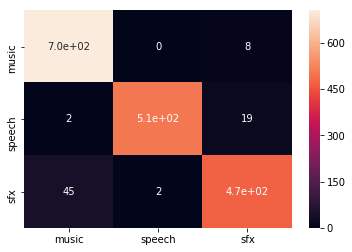

In [10]:
cf_mtx = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
cf_df = pd.DataFrame(cf_mtx, index=labels, columns=labels)
sns.heatmap(cf_df, annot=True)

Again, feed the testing data to save a full nice usuable model

Here we can't save the model with the save function (I am unsure why, something to do with keras and input shapes) so we will save it as two files, a `.json` with the model architecture and a `.h5` with the model weights.

In [11]:
model_json = model.to_json()
with open('music_speech_sfx_discriminator.json', 'w') as f:
    f.write(model_json)
    
model.save_weights('music_speech_sfx_discriminator.h5')